<a href="https://colab.research.google.com/github/joaochenriques/WaveEnergyStatistics/blob/main/WaveEnergyStatistics_IST_PAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wave energy statistics from 2002 to 2024

In [28]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as mpl
import sys, pathlib
import itertools
from scipy import optimize
from sortedcontainers import SortedDict, SortedSet
import re

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

import pathlib, subprocess

def cmdcall( cmd ):
    output = subprocess.getoutput( cmd )
    print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( 'curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py' )

import mpl_utils as mut
mut.config_plots()

markers = ( 'o', '^', 's', 'v', 'H', 'X', 'P' )

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [29]:
cmdcall( 'wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf' )
matplotlib.font_manager.fontManager.addfont('Roboto-Regular.ttf')
# import matplotlib.font_manager
# for f in matplotlib.font_manager.fontManager.ttflist:
#     print(f.name)

--2024-09-14 22:02:11--  https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf [following]
--2024-09-14 22:02:11--  https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145348 (142K) [application/octet-stream]
Saving to: ‘Roboto-Regular.ttf.1’

     0K .......... .......... .......... .......... .......... 35% 18.0M 0s
    50K .......... .......... .......... .......... .......... 70%  109M 0s
   100K .......... .......... 

In [30]:
cmdcall( 'pip install pylatex' )
from pylatex import LongTable, Tabular, MultiColumn, MultiRow, TextColor
from pylatex.utils import bold

In [31]:
cmdcall( 'pip install font-roboto' )

In [32]:
cmdcall( 'pip install unidecode' )
from unidecode import unidecode

In [33]:
cmdcall( 'pip install dataclassy' )
from dataclassy import dataclass

In [34]:
cmdcall( 'pip install iso3166' )
from iso3166 import countries

country_lst = []
for c in countries:
    country_lst.append( c.name )

In [35]:
def left_align( df ):
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

In [36]:
filename = 'scimagojr 2023.csv'

#if not pathlib.Path( f"{filename}").exists():
#    cmdcall( f'curl -O https://raw.githubusercontent.com/joaochenriques/PAS_STATS/main/{filename}' )

df_Q = pd.read_csv( filename, sep=";" )

df_Q.keys()

Index(['Rank', 'Sourceid', 'Title', 'Type', 'Issn', 'SJR', 'SJR Best Quartile',
       'H index', 'Total Docs. (2023)', 'Total Docs. (3years)', 'Total Refs.',
       'Total Cites (3years)', 'Citable Docs. (3years)',
       'Cites / Doc. (2years)', 'Ref. / Doc.', '%Female', 'Overton', 'SDG',
       'Country', 'Region', 'Publisher', 'Coverage', 'Categories', 'Areas'],
      dtype='object')

In [37]:
query = \
'''
KEY(WAVE-ENERGY) AND PUBYEAR AFT 1997 AND DOCTYPE(ar OR re) AND
(
    SRCTITLE( "IEEE Transactions on Sustainable Energy" ) OR
    SRCTITLE( "Renewable and Sustainable Energy Reviews" ) OR
    SRCTITLE( "Applied Energy" ) OR
    SRCTITLE( "Energy Conversion and Management" ) OR
    SRCTITLE( "Energy Conversion and Management X" ) OR
    SRCTITLE( "IEEE Transactions on Energy Conversion" ) OR
    SRCTITLE( "IEEE Transactions on Control Systems Technology" ) OR
    SRCTITLE( "Energy" ) OR SRCTITLE( "Renewable Energy" ) OR
    SRCTITLE( "Sustainable Energy Technologies and Assessments" ) OR
    SRCTITLE( "Journal of Fluid Mechanics" ) OR
    SRCTITLE( "Coastal Engineering" ) OR
    SRCTITLE( "Nonlinear Dynamics" ) OR
    SRCTITLE( "Ocean Engineering" ) OR
    SRCTITLE( "IEEE Journal of Oceanic Engineering" ) OR
    SRCTITLE( "Applied Ocean Research" ) OR
    SRCTITLE( "Marine Structures" ) OR
    SRCTITLE( "Energy Reports" ) OR
    SRCTITLE( "Journal of Fluids and Structures" ) OR
    SRCTITLE( "Frontiers in Marine Science" ) OR
    SRCTITLE( "Scientific Reports" ) OR
    SRCTITLE( "Journal of Hydrodynamics" ) OR
    SRCTITLE( "IET Renewable Power Generation" ) OR
    SRCTITLE( "Energies" ) OR
    SRCTITLE( "IET Electric Power Applications" ) OR
    SRCTITLE( "Ships and Offshore Structures" ) OR
    SRCTITLE( "Frontiers in Energy Research" ) OR
    SRCTITLE( "Journal of Marine Science and Engineering" ) OR
    SRCTITLE( "Journal of Offshore Mechanics and Arctic Engineering" ) OR
    SRCTITLE( "Journal of Ocean Engineering and Marine Energy" ) OR
    SRCTITLE( "Journal of Marine Science and Application" )
)
'''

In [54]:
DB_journals = SortedSet()

for line in query.split( '\n'):
    name = re.findall('"([^"]*)"', line )
    if name:
        DB_journals.update( name )
DB_journals

SortedSet(['Applied Energy', 'Applied Ocean Research', 'Coastal Engineering', 'Energies', 'Energy', 'Energy Conversion and Management', 'Energy Conversion and Management X', 'Energy Reports', 'Fluids', 'Frontiers in Energy Research', 'Frontiers in Marine Science', 'IEEE Journal of Oceanic Engineering', 'IEEE Transactions on Control Systems Technology', 'IEEE Transactions on Energy Conversion', 'IEEE Transactions on Sustainable Energy', 'IET Electric Power Applications', 'IET Renewable Power Generation', 'Journal of Fluid Mechanics', 'Journal of Fluids and Structures', 'Journal of Hydrodynamics', 'Journal of Marine Science and Application', 'Journal of Marine Science and Engineering', 'Journal of Ocean Engineering and Marine Energy', 'Journal of Offshore Mechanics and Arctic Engineering', 'Marine Structures', 'Nature Communications', 'Nonlinear Dynamics', 'Ocean Engineering', 'Renewable Energy', 'Renewable and Sustainable Energy Reviews', 'Scientific Reports', 'Ships and Offshore Struct

In [55]:
DB_journals_lwr = list( map( lambda x: x.lower(), DB_journals ) )

for n, ( journal, Qn ) in enumerate( zip( df_Q['Title'], df_Q['SJR Best Quartile'] ) ):
    if journal.lower() in DB_journals_lwr and Qn < 'Q3':
        print( f'LIMIT-TO ( EXACTSRCTITLE , "{journal}" ) OR ' )

LIMIT-TO ( EXACTSRCTITLE , "Nature Communications" ) OR 
LIMIT-TO ( EXACTSRCTITLE , "IEEE Transactions on Sustainable Energy" ) OR 
LIMIT-TO ( EXACTSRCTITLE , "Renewable and Sustainable Energy Reviews" ) OR 
LIMIT-TO ( EXACTSRCTITLE , "Applied Energy" ) OR 
LIMIT-TO ( EXACTSRCTITLE , "Energy Conversion and Management" ) OR 
LIMIT-TO ( EXACTSRCTITLE , "IEEE Transactions on Energy Conversion" ) OR 
LIMIT-TO ( EXACTSRCTITLE , "IEEE Transactions on Control Systems Technology" ) OR 
LIMIT-TO ( EXACTSRCTITLE , "Energy" ) OR 
LIMIT-TO ( EXACTSRCTITLE , "Renewable Energy" ) OR 
LIMIT-TO ( EXACTSRCTITLE , "Sustainable Energy Technologies and Assessments" ) OR 
LIMIT-TO ( EXACTSRCTITLE , "Journal of Fluid Mechanics" ) OR 
LIMIT-TO ( EXACTSRCTITLE , "Coastal Engineering" ) OR 
LIMIT-TO ( EXACTSRCTITLE , "Nonlinear Dynamics" ) OR 
LIMIT-TO ( EXACTSRCTITLE , "Ocean Engineering" ) OR 
LIMIT-TO ( EXACTSRCTITLE , "IEEE Journal of Oceanic Engineering" ) OR 
LIMIT-TO ( EXACTSRCTITLE , "Applied Ocean Res

In [71]:
filename = 'scopus_20240914_since_1999.csv'

if not pathlib.Path( f"{filename}").exists():
    cmdcall( f'curl -O https://raw.githubusercontent.com/joaochenriques/PAS_STATS/main/{filename}' )

df = pd.read_csv( filename )

In [72]:
authors_lst = df['Authors']
authors_ID_lst = df['Author(s) ID']
affiliations_lst = df['Affiliations']
title_lst = df['Title']
journal_lst = df['Source title']
year_lst = df['Year']
citations_lst = df['Cited by']
DOI_lst = df['DOI']
stage_lst = df['Publication Stage']

replacements_dic = {
    'Ireland (formerly at the University of Plymouth)': 'Ireland',
    'Univ. Paris6': 'France',
    'Chinese Academy of Sciences': 'China',
    'Instituto Superior Tx000E9': 'Portugal'
}

# Max number of table entries

In [73]:
max_entries = 10

global_tab = {}

# Countries ordered by percentage of the authors's country

In [74]:
countries_frac_dic = {}
total_valid_papers = 0

for n, ( affiliations, stage ) in enumerate( zip( affiliations_lst, stage_lst ) ):
    if stage == 'Final' and affiliations == affiliations: # detect NANs
        total_valid_papers += 1

        institutions_lst = affiliations.split( ';' )
        frac = 1.0 / len(institutions_lst)

        for institution in institutions_lst:
            country = institution.rsplit( ',', 1 )[-1].strip()

            if country in replacements_dic:
                country = replacements_dic[country]

            if not country in countries_frac_dic:
                countries_frac_dic[country] = frac
            else:
                countries_frac_dic[country] += frac

sorted_country_frac_rank = { k: v for k, v in sorted( countries_frac_dic.items(), key=lambda item: item[1], reverse=True ) }

df_country_name_lst = []
df_country_num_lst = []

col_name = f"Num papers out of {total_valid_papers}"
df_country_dic = {
        "Country": df_country_name_lst,
        col_name: df_country_num_lst
}

for n, ( name, num ) in enumerate( sorted_country_frac_rank.items() ):
    if n == max_entries: break
    df_country_name_lst.append( name )
    df_country_num_lst.append( int(num) )

df = pd.DataFrame( df_country_dic )
df.index = df.index + 1
df.head(20)

,Country,Num papers out of 4958
1,China,1143
2,United States,546
3,United Kingdom,478
4,Portugal,261
5,Spain,226
6,Italy,225
7,Australia,197
8,India,188
9,Ireland,180
10,Sweden,134


# Papers per author

In [75]:
@dataclass
class data:
    name: str = None
    num_papers: int = 0
    citations: int = 0

In [76]:
papers_dic = {}

for n, ( authors, authors_ID, citations, DOI, stage ) in enumerate( zip( authors_lst, authors_ID_lst, citations_lst, DOI_lst, stage_lst ) ):
    if stage == 'Final' and authors == authors and authors_ID == authors_ID: # check NANs
        for ( author, ID ) in zip( authors.split(';'), str( authors_ID ).split(';') ):
            author = author.strip()
            ID = ID.strip()

            if ID in papers_dic:
                papers_dic[ID].num_papers += 1
                papers_dic[ID].citations += int(citations)
            else:
                papers_dic[ID] = data( author, 1, int(citations) )

In [77]:
sorted_papers_dic = { k: v for k, v in sorted( papers_dic.items(), key=lambda item: item[1].num_papers, reverse=True ) }

df_authors_name_lst = []
df_authors_num_lst = []

df_authors_dic = {
        "Author": df_authors_name_lst,
        "Num papers": df_authors_num_lst
}

for n, dt in enumerate( sorted_papers_dic.values() ):
    if n == max_entries: break
    df_authors_name_lst.append( dt.name )
    df_authors_num_lst.append( dt.num_papers )


df = pd.DataFrame( df_authors_dic )
df.index = df.index + 1

left_align( df.head(20) )

,Author,Num papers
1,Ringwood J.V.,115
2,Iglesias G.,88
3,Guedes Soares C.,76
4,Gato L.M.C.,68
5,Shi H.,65
6,Henriques J.C.C.,65
7,Greaves D.,60
8,Falcão A.F.O.,59
9,Taveira-Pinto F.,55
10,Leijon M.,53


# Citations per author

In [78]:
sorted_citations_dic = { k: v for k, v in sorted( papers_dic.items(), key=lambda item: item[1].citations, reverse=True ) }

df_citations_name_lst = []
df_citations_num_lst = []

df_citations_dic = {
        "Author": df_citations_name_lst,
        "Citations": df_citations_num_lst
}

for n, dt in enumerate( sorted_citations_dic.values() ):
    if n == max_entries: break
    df_citations_name_lst.append( dt.name )
    df_citations_num_lst.append( dt.citations )

df = pd.DataFrame( df_citations_dic )
df.index = df.index + 1
left_align( df.head(20) )

,Author,Citations
1,Falcão A.F.O.,7338
2,Wang Z.L.,6515
3,Iglesias G.,6325
4,Ringwood J.V.,4605
5,Guedes Soares C.,3305
6,Henriques J.C.C.,3013
7,Babarit A.,2924
8,Moan T.,2904
9,Jiang T.,2773
10,Greaves D.,2596


# Most cited papers

In [79]:
@dataclass
class paper_rank:
    authors: str = None
    title: str = None
    journal: str =None
    year: int = 0
    DOI: str = None
    citations: int = 0

In [80]:
papers_rank_dic = {}

for n, ( authors, title, journal, year, DOI, citations, stage ) in enumerate( zip( authors_lst, title_lst, journal_lst, year_lst, DOI_lst, citations_lst, stage_lst ) ):
    if stage == 'Final' and authors == authors: # check NANs
        papers_rank_dic[DOI] = paper_rank( authors, title, journal, year, DOI, int( citations ) )

In [81]:
sorted_papers_rank_dic = { k: v for k, v in sorted( papers_rank_dic.items(), key=lambda item: item[1].citations, reverse=True ) }

df_authors_name_lst = []
df_title_lst = []
df_journal_lst = []
df_year_lst = []
df_DOI_lst = []
df_citations_lst = []

df_papers_rank_dic = {
        "Authors": df_authors_name_lst,
        "Title": df_title_lst,
        "Journal": df_journal_lst,
        "Year": df_year_lst,
        # "DOI": df_DOI_lst,
        "citations": df_citations_lst
}


for n, dt in enumerate( sorted_papers_rank_dic.values() ):
    df_authors_name_lst.append( dt.authors )
    df_title_lst.append( dt.title )
    df_journal_lst.append( dt.journal )
    df_year_lst.append( dt.year )
    df_DOI_lst.append( dt.DOI )
    df_citations_lst.append( dt.citations )

# df_authors_name_lst[0] = 'Falcão A.F.O.'

df = pd.DataFrame( df_papers_rank_dic )
df.index = df.index + 1
left_align( df.head(10) )

,Authors,Title,Journal,Year,citations
1,Falcão A.F.d.O.,Wave energy utilization: A review of the technologies,Renewable and Sustainable Energy Reviews,2010,2310
2,Drew B.; Plummer A.R.; Sahinkaya M.N.,A review of wave energy converter technology,"Proceedings of the Institution of Mechanical Engineers, Part A: Journal of Power and Energy",2009,981
3,Wang Z.L.; Jiang T.; Xu L.,Toward the blue energy dream by triboelectric nanogenerator networks,Nano Energy,2017,944
4,Clément A.; McCullen P.; Falcão A.; Fiorentino A.; Gardner F.; Hammarlund K.; Lemonis G.; Lewis T.; Nielsen K.; Petroncini S.; Pontes M.-T.; Schild P.; Sjöström B.-O.; Sørensen H.C.; Thorpe T.,Wave energy in Europe: Current status and perspectives,Renewable and Sustainable Energy Reviews,2002,921
5,Falnes J.,A review of wave-energy extraction,Marine Structures,2007,906
6,Falcão A.F.O.; Henriques J.C.C.,Oscillating-water-column wave energy converters and air turbines: A review,Renewable Energy,2016,744
7,López I.; Andreu J.; Ceballos S.; Martínez De Alegría I.; Kortabarria I.,Review of wave energy technologies and the necessary power-equipment,Renewable and Sustainable Energy Reviews,2013,660
8,Babarit A.; Hals J.; Muliawan M.J.; Kurniawan A.; Moan T.; Krokstad J.,Numerical benchmarking study of a selection of wave energy converters,Renewable Energy,2012,634
9,Pérez-Collazo C.; Greaves D.; Iglesias G.,A review of combined wave and offshore wind energy,Renewable and Sustainable Energy Reviews,2015,518
10,Gunn K.; Stock-Williams C.,Quantifying the global wave power resource,Renewable Energy,2012,515


# Generate plot of the papers per year

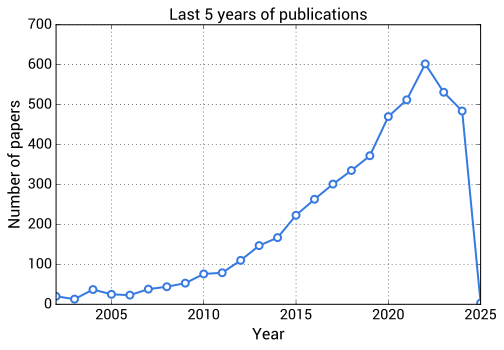

In [82]:
mpl.rc('font', family='Roboto')

# year_dic = {i:0 for i in range( min( year_lst ), max( year_lst )+1 ) }
year_dic = {i:0 for i in range( 1999, 2025+1 ) }

for n, ( year, stage ) in enumerate( zip( year_lst, stage_lst ) ):
    if stage == 'Final' and affiliations == affiliations: # detect NANs
        if year > 1998:
            year_dic[year] += 1

mpl.figure( 1, figsize=(1.2*6,1.2*4) )
mpl.plot( year_dic.keys(), year_dic.values(), 'o-',
         linewidth=2, color='#3679e0',
         markersize=7, markerfacecolor='w', markeredgewidth=2,
         markeredgecolor='#3679e0' )
mpl.xlim( (2002, 2025) )
mpl.grid()
mpl.xlabel( 'Year' )
mpl.ylabel( 'Number of papers' )
mpl.title( 'Last 5 years of publications' )#.set_fontname("Roboto condensed")


mpl.gca().set_axisbelow(True)
# mpl.gca().set_xticks( range( min( year_lst ), max( year_lst )+1, 2 ) );
# mpl.gca().set_xticks( range( 2018, 2023+1, 2 ) );
mpl.savefig( 'PubsLast20Years.pdf', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( 'PubsLast20Years.svg', bbox_inches='tight', pad_inches=0.02 )

# df_year_dic = {
#     'Year': year_dic.keys(),
#     'Num papers': year_dic.values()
# }

# df = pd.DataFrame( df_year_dic )
# df.index = df.index + 1
# df

# Generate latex table summary

In [83]:
C1_Countries  = list( df_country_dic.values() )[0]
C1_num_papers = list( df_country_dic.values() )[1]

C2_Author     = list( df_authors_dic.values() )[0]
C2_num_papers = list( df_authors_dic.values() )[1]

C3_Author  = list( df_citations_dic.values() )[0]
C3_num_cit = list( df_citations_dic.values() )[1]

In [84]:
for n in range( max_entries ):
    if 'Portugal' in C1_Countries[n]:
        C1_Countries[n] = bold( C1_Countries[n] )
    if 'Henriques' in C2_Author[n]:
        C2_Author[n] = bold( C2_Author[n] )
    if 'Henriques' in C3_Author[n]:
        C3_Author[n] = bold( C3_Author[n] )

In [85]:
data_table = Tabular('|c|cl|cl|cl|')
data_table.add_hline()

data_table.add_row( ( MultiRow(2, data='Ordem'), MultiRow(2, data='País'), 'Número', MultiRow(2, data='Autor'), 'Número', MultiRow(2, data='Autor'), 'Número' ) )
data_table.add_row( ( '', '', 'artigos', '', 'artigos', '', 'citações' ) )

data_table.add_hline()
data_table.add_hline()

for n in range( max_entries ):
    row = [n+1, C1_Countries[n], C1_num_papers[n],
                C2_Author[n], C2_num_papers[n],
                C3_Author[n], C3_num_cit[n] ]

    if n % 2 == 0:
        data_table.add_row( row, color='shadecolor' )
    else:
        data_table.add_row( row )
data_table.add_hline()

data_table.generate_tex('tablefile')